In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from scipy.interpolate import interp1d

from siphon.simplewebservice.wyoming import WyomingUpperAir
from mmctools.helper_functions import calc_wind, T_to_Tv, theta
from mmctools.plotting import plot_profile

In [2]:
#sounding_location = 'OKX' # Upton, NY (Long Island)
#sounding_location = 'CHH' # Chatham, MA (Cape Cod)
#sounding_location = 'IAD' # Dulles, VA
#sounding_location = 'WAL' # Wallops Island, VA
#sounding_location = 'MHX' # Newport, NC
#sounding_location = 'GYX' # Gray, ME
sounding_locations = {
    'OKX': 'Long Island, NY',
    'CHH': 'Cape Cod, MA',
    'WAL': 'Wallops Island, VA',
    'MHX': 'Newport, NC',
}
sounding_datetimes = pd.date_range(pd.to_datetime('2019-05-15 00:00'), pd.to_datetime('2019-05-16 12:00'), freq='12h')

In [3]:
datadir = 'data'
os.makedirs(datadir, exist_ok=True)

## download all soundings

In [4]:
for location in sounding_locations.keys():
    for datetime in sounding_datetimes:
        dtstr = datetime.strftime('%Y%m%d_%HZ')
        soundingfile = os.path.join(datadir, f'{location}_{dtstr}.csv')
        if not os.path.isfile(soundingfile):
            # Note: this can result in an HTTPError if called too often...
            wyo = WyomingUpperAir.request_data(datetime.to_pydatetime(), location)
            wyo.to_csv(soundingfile, index=False)
            print('Wrote',soundingfile)

## process all downloaded soundings

In [5]:
def process_soundings_at_station(stationid,maxheight=5000.,dz=10.):
    allheights = np.arange(0,maxheight+dz,dz)
    dslist = []
    for datetime in sounding_datetimes:
        dtstr = datetime.strftime('%Y%m%d_%HZ')
        soundingfile = os.path.join(datadir, f'{stationid}_{dtstr}.csv')
        print('processing',soundingfile)
        df = pd.read_csv(soundingfile,parse_dates=['time'])
        assert np.all(df['time'] == datetime)
        assert all([sta == stationid for sta in df['station']])
        df = df.drop(columns=['time','station'])
        df['height'] -= df['elevation']
        df['temperature'] += 273.15
        df['dewpoint'] += 273.15
        df['Tv'] = T_to_Tv(df['temperature'], Td=df['dewpoint'], p=df['pressure'])
        df['thetav'] = theta(df['Tv'], p=df['pressure'])
        df = df.set_index('height')
        zmax = df.loc[df.index >= maxheight].index[0]
        df = df.loc[df.index <= zmax]
        interpfun = interp1d(df.index, df, kind='linear', axis=0)
        dfnew = pd.DataFrame(columns=df.columns, index=pd.Index(allheights,name='height'), dtype=float)
        for z in allheights:
            dfnew.loc[z] = interpfun(z)
        dfnew['speed'],dfnew['direction'] = calc_wind(dfnew,u='u_wind',v='v_wind')
        ds = xr.Dataset.from_dataframe(dfnew)
        ds = ds.assign_coords({
            'station': ('station',[stationid]),
            'datetime': ('datetime',[datetime]),
        })
        dslist.append(ds)
    return xr.concat(dslist,dim='datetime')

In [6]:
soundings = xr.concat([process_soundings_at_station(location) for location in sounding_locations.keys()], dim='station')

processing data/OKX_20190515_00Z.csv
processing data/OKX_20190515_12Z.csv
processing data/OKX_20190516_00Z.csv
processing data/OKX_20190516_12Z.csv
processing data/CHH_20190515_00Z.csv
processing data/CHH_20190515_12Z.csv
processing data/CHH_20190516_00Z.csv
processing data/CHH_20190516_12Z.csv
processing data/WAL_20190515_00Z.csv
processing data/WAL_20190515_12Z.csv
processing data/WAL_20190516_00Z.csv
processing data/WAL_20190516_12Z.csv
processing data/MHX_20190515_00Z.csv
processing data/MHX_20190515_12Z.csv
processing data/MHX_20190516_00Z.csv
processing data/MHX_20190516_12Z.csv


In [7]:
soundings

<xarray.Dataset>
Dimensions:         (datetime: 4, height: 501, station: 4)
Coordinates:
  * datetime        (datetime) datetime64[ns] 2019-05-15 ... 2019-05-16T12:00:00
  * height          (height) float64 0.0 10.0 20.0 ... 4.98e+03 4.99e+03 5e+03
  * station         (station) object 'OKX' 'CHH' 'WAL' 'MHX'
Data variables:
    pressure        (station, datetime, height) float64 1.007e+03 ... 548.0
    temperature     (station, datetime, height) float64 282.5 282.5 ... 263.4
    dewpoint        (station, datetime, height) float64 280.9 280.2 ... 233.4
    direction       (station, datetime, height) float64 360.0 292.0 ... 315.6
    speed           (station, datetime, height) float64 0.0 0.303 ... 44.71
    u_wind          (station, datetime, height) float64 0.0 0.281 ... 31.26
    v_wind          (station, datetime, height) float64 -0.0 -0.1135 ... -31.97
    station_number  (station, datetime, height) float64 7.25e+04 ... 7.230e+04
    latitude        (station, datetime, height) float64 40.87 40.87 ... 34.78
    longitude       (station, datetime, height) float64 -72.86 -72.86 ... -76.88
    elevation       (station, datetime, height) float64 20.0 20.0 ... 11.0 11.0
    Tv              (station, datetime, height) float64 283.7 283.6 ... 263.4
    thetav          (station, datetime, height) float64 283.1 283.2 ... 312.9

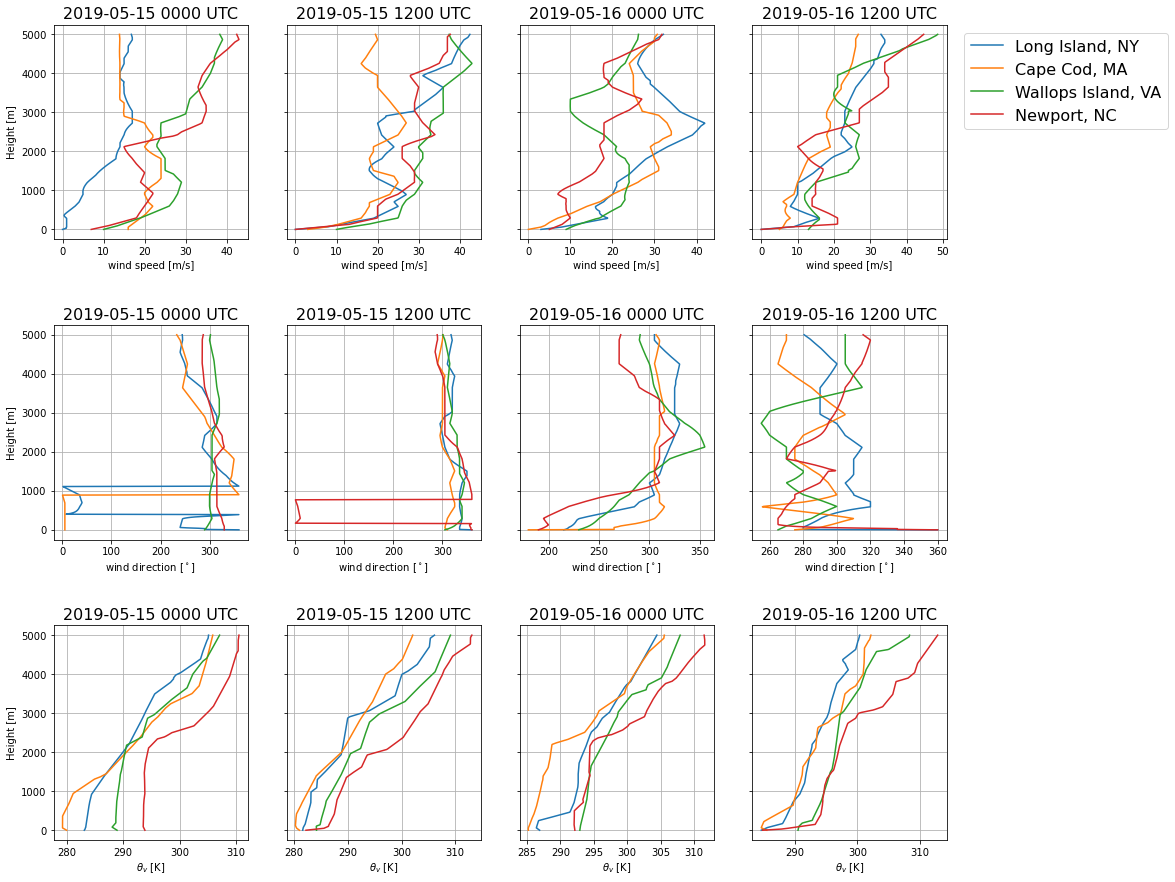

In [8]:
toplot = {
    sounding_locations[name]: soundings.sel(station=name).to_dataframe()
    for name in soundings.coords['station'].values
}
fig,ax = plot_profile(toplot,
                      fields=['speed','direction','thetav'],
                      fieldlabels={'speed':r'wind speed [m/s]', 'direction':r'wind direction [$^\circ$]'},
                      times=sounding_datetimes,
                      stack_by_datasets=True)